In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv('neo_v2.csv')

In [4]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [5]:
df.nunique()

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64

In [5]:
# Checking if id's have been previously labeled as hazardous
id_group = df.groupby('id').sum()['hazardous']

In [6]:
# Creating a new column that indicates if the id has been previously labeled as hazardous
df['previous_hazard'] = df.apply(lambda x: id_group[x['id']] > 1, axis=1)

In [23]:
df.corr()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous,previous_hazard
id,1.000000,-0.148322,-0.148322,-0.059176,-0.056510,0.277258,-0.123443,-0.122682
est_diameter_min,-0.148322,1.000000,1.000000,0.221553,0.142241,-0.560188,0.183363,0.176190
est_diameter_max,-0.148322,1.000000,1.000000,0.221553,0.142241,-0.560188,0.183363,0.176190
relative_velocity,-0.059176,0.221553,0.221553,1.000000,0.327169,-0.353863,0.191185,0.184519
miss_distance,-0.056510,0.142241,0.142241,0.327169,1.000000,-0.264168,0.042302,0.051964
absolute_magnitude,0.277258,-0.560188,-0.560188,-0.353863,-0.264168,1.000000,-0.365267,-0.354000
hazardous,-0.123443,0.183363,0.183363,0.191185,0.042302,-0.365267,1.000000,0.971680
previous_hazard,-0.122682,0.176190,0.176190,0.184519,0.051964,-0.354000,0.971680,1.000000


In [5]:
df.groupby('previous_hazard').sum()['hazardous']

previous_hazard
False     448
True     8392
Name: hazardous, dtype: int64

In [6]:
# Using Spearman correolation over Spearman, since Spearman doesnt assume linear relationship
df.corr(method='spearman')['est_diameter_min']

id                   -0.500122
est_diameter_min      1.000000
est_diameter_max      1.000000
relative_velocity     0.335507
miss_distance         0.269061
sentry_object              NaN
absolute_magnitude   -1.000000
hazardous             0.374830
previous_hazard       0.363730
Name: est_diameter_min, dtype: float64

In [7]:
# Dropping unnecesary columns (dropping est_diameters since they are perfectly correlated with absolute magnitude and with each other)
df.drop(['sentry_object', 'orbiting_body', 'est_diameter_min', 'est_diameter_max', 'name', 'id'], axis=1, inplace=True)

In [8]:
df.head()

,relative_velocity,miss_distance,absolute_magnitude,hazardous,previous_hazard
0,13569.249224,5.483974e+07,16.73,False,False
1,73588.726663,6.143813e+07,20.00,True,True
2,114258.692129,4.979872e+07,17.83,False,False
3,24764.303138,2.543497e+07,22.20,False,False
4,42737.733765,4.627557e+07,20.09,True,True


# Exploratory Data Analysis

<AxesSubplot:xlabel='miss_distance', ylabel='Count'>

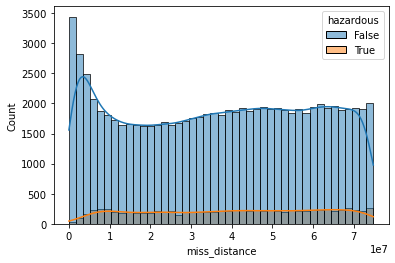

In [24]:
sns.histplot(data=df, x='miss_distance', hue='hazardous', kde=True)

<AxesSubplot:xlabel='relative_velocity', ylabel='Count'>

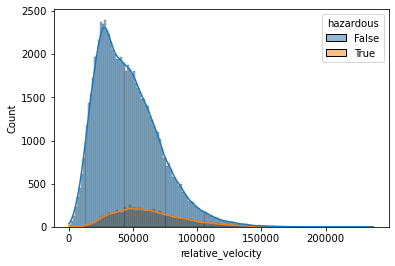

In [25]:
sns.histplot(data=df, x='relative_velocity', hue='hazardous', kde=True)

<AxesSubplot:xlabel='absolute_magnitude', ylabel='Count'>

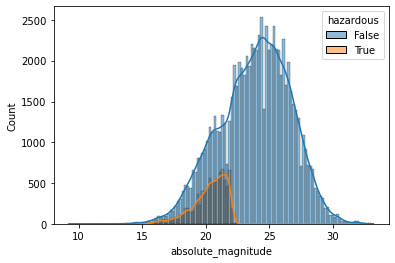

In [26]:
sns.histplot(data=df, x='absolute_magnitude', hue='hazardous', kde=True)

<AxesSubplot:>

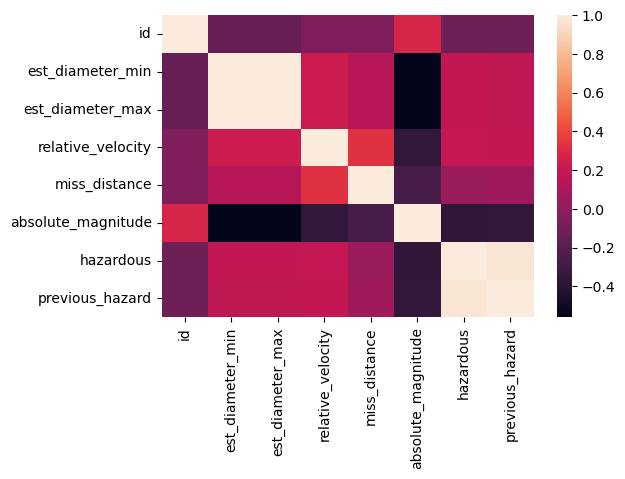

In [28]:
# Plotting heatmap to see correlation between features and hazardous classification
# There is a very high correlation between previous classification as hazardous and current classification
plt.figure(figsize=(6,4), dpi=100)
sns.heatmap(df.corr())

# Modeling

In [8]:
X = df.drop('hazardous', axis=1)
y = df['hazardous']

In [9]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_cv)
scaled_X_test = scaler.transform(X_test)

In [34]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=100)

In [66]:
xgb_model.fit(scaled_X_train, y_cv)

C:\Users\alexi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:02:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=100, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
y_pred = xgb_model.predict(scaled_X_test)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      8232
        True       0.83      0.98      0.90       852

    accuracy                           0.98      9084
   macro avg       0.91      0.98      0.94      9084
weighted avg       0.98      0.98      0.98      9084



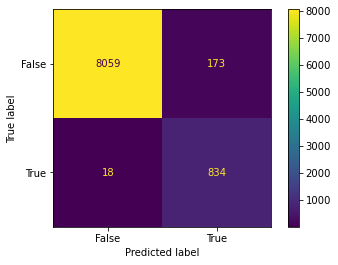

In [41]:
ConfusionMatrixDisplay.from_estimator(xgb_model, scaled_X_test, y_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

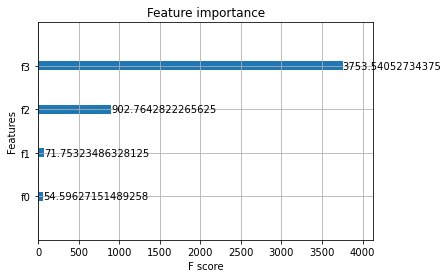

In [56]:
xgb.plot_importance(xgb_model, importance_type='gain')

In [76]:
scores = pd.Series(xgb_model.get_booster().get_score(importance_type='gain'))

In [107]:
final_scores = pd.Series(data=scores.values, index=X.columns).sort_values(ascending=False)

In [108]:
final_scores

previous_hazard       3753.540527
absolute_magnitude     902.764282
miss_distance           71.753235
relative_velocity       54.596272
dtype: float64

Text(0, 0.5, 'Features')

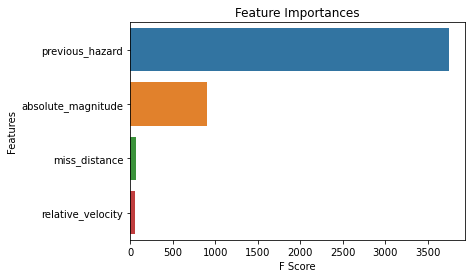

In [111]:
sns.barplot(x=final_scores.values, y=final_scores.index)
plt.title('Feature Importances')
plt.xlabel('F Score')
plt.ylabel('Features')